In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.cluster import DBSCAN
from sklearn import metrics
import pylab as pl
from scipy.spatial import ConvexHull, convex_hull_plot_2d

# from matplotlib import animation, rc
# from IPython.display import HTML
from IPython import display
pl.ion()

In [2]:
!pwd

/home/tarang/Lidar_Project_Fall_2019_Tarang/April2020/Lidar_curb_detection/source/vscan_only


In [3]:
def visualize_dbscan(db):
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

    #     xy = X[class_member_mask & ~core_samples_mask]
    #     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
    #              markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()

351
Original Points: 351


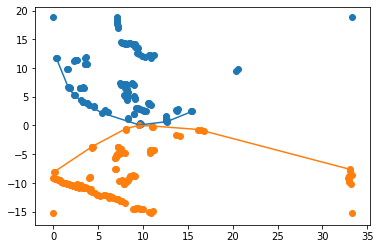

In [5]:
def detect_boundary_2priors(df):
    # Convert to numpy and do DBScan clustering
    X = df.to_numpy()[:,:2]
    db = DBSCAN(eps=0.5, min_samples=2).fit(X)

    # Visualize dbscan clusters
    # visualize_dbscan(db)

    print("Original Points:",df.to_numpy()[:,:2].shape[0])

    # visualize points that were clustered
    # pl.scatter(X[db.core_sample_indices_][:,0],X[db.core_sample_indices_][:,1])

    filtered_X = X[db.core_sample_indices_]

    # using 2 priors for now (y>0 and y<0)
    # prior1 = df[df.y>0].to_numpy()[:,:2]
    # prior2 = df[df.y<=0].to_numpy()[:,:2]
    prior1= filtered_X[filtered_X[:,1]>0,:]
    prior2 = filtered_X[filtered_X[:,1]<=0,:]



    # # add points to prior
    # 0,maxY and maxX,maxY to prior1
    # 0, minY and maxX,minY to prior2

    maxX = np.max(filtered_X[:,0])
    maxY = np.max(filtered_X[:,1])
    minY = np.min(filtered_X[:,1])
    # print(prior1.shape, prior2.shape)
    # print(maxX,maxY,minY)
    prior1 = np.vstack([prior1,np.array([[0,maxY],[maxX,maxY]])])
    prior2 = np.vstack([prior2,np.array([[0,minY],[maxX,minY]])])
    # print(prior1.shape, prior2.shape)

    # plot priors
    # pl.scatter(prior1[:,0],prior1[:,1])
    # pl.scatter(prior2[:,0],prior2[:,1])

    # convex hull for priors
    hull1 = ConvexHull(prior1)
    hull2 = ConvexHull(prior2)

    added_vertices_prior1 = [prior1.shape[0]-1,prior1.shape[0]-2]
    added_vertices_prior2 = [prior2.shape[0]-1,prior2.shape[0]-2]


    v1 = list(hull1.vertices)
    for v in added_vertices_prior1:
        v1.remove(v)

    v2 = list(hull2.vertices)
    for v in added_vertices_prior2:
        v2.remove(v)

    boundary1 = prior1[v1]
    boundary2 = prior2[v2]
    
    priors = [prior1,prior2]
    boundaries = [boundary1,boundary2]
    return priors,boundaries
    
# load data
# csvs = sorted(glob.glob("./frame_pointclouds/*.csv"))
df = pd.read_csv("./frame_pointclouds/frame_93.csv")
print(len(df))

priors, boundaries = detect_boundary_2priors(df)

for idx,prior in enumerate(priors):
    # visualize points and line
    pl.scatter(prior[:,0],prior[:,1])
    pl.plot(boundaries[idx][:,0],boundaries[idx][:,1])
#     pl.scatter(prior2[:,0],prior2[:,1])
#     pl.plot(boundary2[:,0],boundary2[:,1])